**Library**

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import  datetime
import calendar 
import time 


**Google Drive**


In [0]:
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 20.7MB/s 
  Running setup.py bdist_wheel for PyDrive ... - \ done
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built PyDrive


In [0]:
runtime= time.time() #Get the current time 

#Get the parking citation csv file from the google drive 
if os.path.exists("parking-citations.csv"):
  print("Parking citation csv already exists")
else:
  download_test = drive.CreateFile({'id': '1VLvTcMT4R015_GkdcyvADscydwSF58Ol'}) #id of the file that contains the dataset(google drive)
  citation_file = download_test.GetContentFile('citation.zip')
#unzip the citation file 
!unzip citation.zip

Archive:  citation.zip
  inflating: parking-citations.csv   


In [0]:
#Read the parking csv file 
df = pd.read_csv('parking-citations.csv')
print(list(df)) # column names 
print ('Number of data:',df.shape)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['Ticket number', 'Issue Date', 'Issue time', 'Meter Id', 'Marked Time', 'RP State Plate', 'Plate Expiry Date', 'VIN', 'Make', 'Body Style', 'Color', 'Location', 'Route', 'Agency', 'Violation code', 'Violation Description', 'Fine amount', 'Latitude', 'Longitude']
Number of data: (8434069, 19)


In [0]:
# Upload the filename to the google drive
def upload_file(filename,dataframe):
  dataframe.to_csv(filename,index=False)
  uploaded = drive.CreateFile({'title': filename,'parents':[{u'id': '1QVRA8TWmdwXtRF7N1RXqN2PkwXo8jYHU'}]})#id of the folder to be store in the google drive 
  uploaded.SetContentFile(filename)
  uploaded.Upload()
  print('Uploaded file with ID {}'.format(uploaded.get('id')))


In [0]:
def getLocation(location):

  i=0
  list= np.empty((len(location),1),dtype="U20")
  for data in location:
    temp=data.split(None, 1)[0]
    if temp.isnumeric():
      data=data[len(temp)+1:]
    list[i]=data
    i=i+1
  return list

In [0]:
temp=  df['Location'].dropna()
location=pd.DataFrame()
location['Quantity']=np.ones(len(temp),dtype=int)
location['Location']=getLocation(temp)
location['Quantity']=location['Quantity'].groupby(location['Location']).transform('sum')
location['%'] = (location['Quantity']/len(location))*100
location=location.drop_duplicates(['Location']).sort_values(by = ['Quantity'], ascending = [False])
print(location.head(20))

#upload_file('location.csv',location)

      Quantity          Location         %
3031    130481        VENTURA BL  1.547210
1096     45413         WALL ST S  0.538496
873      42972         MAIN ST S  0.509551
1293     38732    SAN VICENTE BL  0.459274
716      37002         PICO BL W  0.438760
571      33695  LOS ANGELES ST S  0.399547
875      31833         HOPE ST S  0.377467
905      31786          6TH ST W  0.376910
870      31517         SUNSET BL  0.373720
547      30964    LARCHMONT BL N  0.367163
1095     26986       SANTEE ST S  0.319993
1580     26747    SAN PEDRO ST S  0.317159
1089     26538       MAPLE AVE S  0.314681
778      25171          8TH ST W  0.298471
1529     25033     WILSHIRE BLVD  0.296835
496      25005     FIGUEROA ST S  0.296503
572      23966          7TH ST W  0.284183
1011     23935       GRAND AVE S  0.283815
1107     22625       SPRING ST S  0.268281
664      22239        MELROSE AV  0.263704


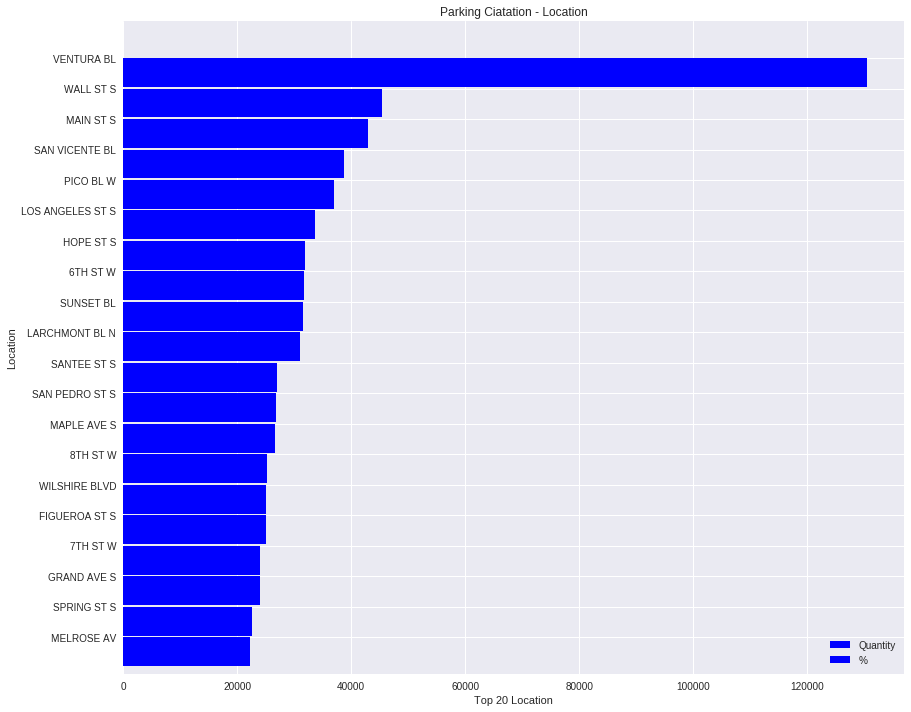

In [0]:
location.groupby(['Location']).sum().sort_values(by= 'Quantity', ascending=True)[-20:].plot(kind='barh',width=1.9,figsize=(14, 12),color='b')
plt.xlabel('Top 20 Location')
plt.title("Parking Ciatation - Location")
plt.show()

In [0]:
#Create all categories for the issue time. The position in the numpy array corresponds to the hour. 
#The time is 24-hour-clock. The time is stored in the position that correspond to the hour 
def create_issue_time_category(issue_time):
  issue_cat= np.zeros(24,dtype=int)
  for issue in issue_time:
    key= int(issue/100) #get the position in the numpy array to be store
    issue_cat[key]=issue_cat[key]+1 
  return issue_cat

issue_time= df['Issue time'].dropna()

list_issue_time=create_issue_time_category(issue_time)

issue= pd.DataFrame()
issue['Issue Time']= np.arange(24) 
issue['Quantity']=list_issue_time
issue['%']=np.zeros(len(issue))
issue['%']= (issue['Quantity']/len(issue_time))*100 #get the average of each time


#upload_file('issueTime.csv',issue)

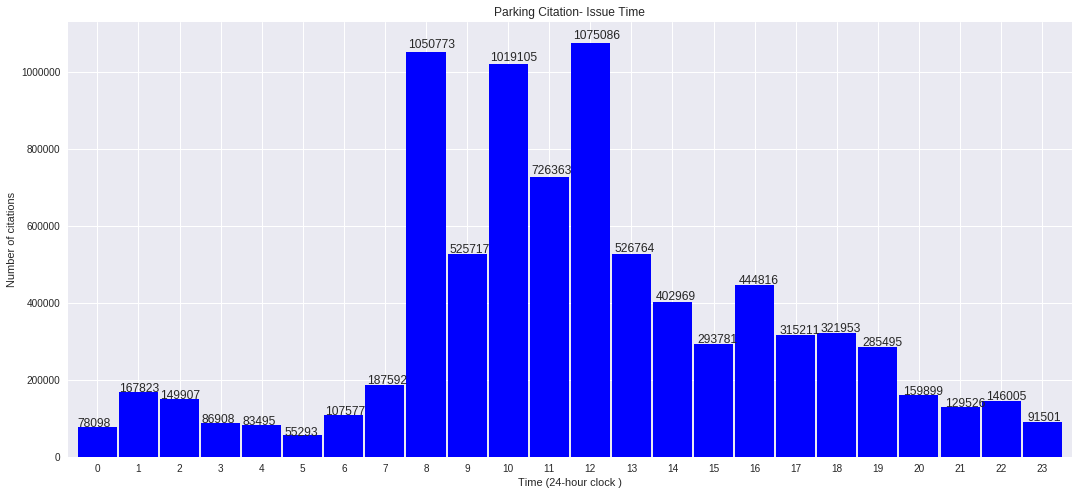

    Issue Time  Quantity          %
12          12   1075086  12.750590
8            8   1050773  12.462236
10          10   1019105  12.086652
11          11    726363   8.614712
13          13    526764   6.247455
9            9    525717   6.235038
16          16    444816   5.275547
14          14    402969   4.779239
18          18    321953   3.818384
17          17    315211   3.738423
15          15    293781   3.484262
19          19    285495   3.385989
7            7    187592   2.224853
1            1    167823   1.990392
20          20    159899   1.896413
2            2    149907   1.777907
22          22    146005   1.731629
21          21    129526   1.536187
6            6    107577   1.275870
23          23     91501   1.085208
3            3     86908   1.030735
4            4     83495   0.990256
0            0     78098   0.926247
5            5     55293   0.655779


In [0]:
#Graph the issue time
ax=issue['Quantity'].plot(kind='bar', figsize=(18, 8), color='b',rot=0,width=0.95)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010))
plt.title("Parking Citation- Issue Time")
plt.xlabel('Time (24-hour clock )')
plt.ylabel('Number of citations')
plt.show()
issue=issue.sort_values(by = ['Quantity'], ascending = [False])
print (issue.head(issue.shape[0]))

In [0]:
#map each data to the adecuated issue time. Return a numpy array that contains all data 
def create_list_near_issue_time(issue_time):  
  
  issue_cat= np.zeros(24,dtype=int)

  for issue in issue_time:
    key= int(issue/100)
   
    if issue%100 <30:
      issue_cat[key]=issue_cat[key]+1
    else:
      if key<23: 
        issue_cat[key+1]=issue_cat[key+1]+1
      else: 
        issue_cat[0]=issue_cat[0]+1
  return issue_cat


issue_time= df['Issue time'].dropna()

list_issue_time=create_list_near_issue_time(issue_time)

issue= pd.DataFrame()
issue['Issue Time']= np.arange(24) #create a culumn with 24 rows for the 24-hour clock
issue['Quantity']=list_issue_time #create list of the issue time 
issue['%']=np.zeros(len(issue))
issue['%']= (issue['Quantity']/len(issue_time))*100 # get the percentage of each time 



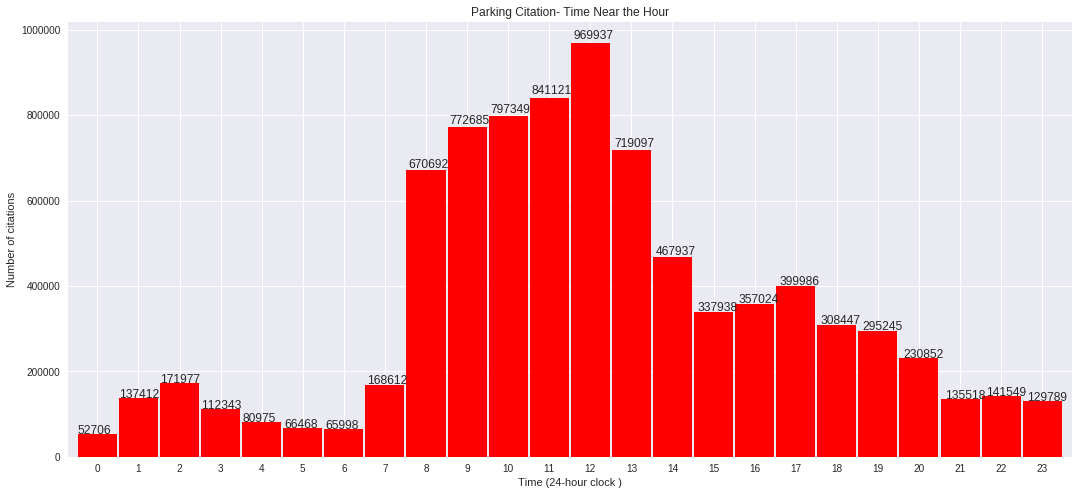

    Issue Time  Quantity          %
12          12    969937  11.503516
11          11    841121   9.975750
10          10    797349   9.456611
9            9    772685   9.164094
13          13    719097   8.528537
8            8    670692   7.954451
14          14    467937   5.549763
17          17    399986   4.743860
16          16    357024   4.234328
15          15    337938   4.007967
18          18    308447   3.658201
19          19    295245   3.501625
20          20    230852   2.737920
2            2    171977   2.039658
7            7    168612   1.999749
22          22    141549   1.678780
1            1    137412   1.629715
21          21    135518   1.607252
23          23    129789   1.539306
3            3    112343   1.332395
4            4     80975   0.960369
5            5     66468   0.788315
6            6     65998   0.782741
0            0     52706   0.625097


In [0]:
#Graph for the near to the issue time
ax=issue['Quantity'].plot(kind='bar', figsize=(18, 8), color='r',rot=0,width=0.95)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.010))
plt.title("Parking Citation- Time Near the Hour")
plt.xlabel('Time (24-hour clock )')
plt.ylabel('Number of citations')
plt.show()
issue=issue.sort_values(by = ['Quantity'], ascending = [False])
print (issue.head(issue.shape[0]))

In [0]:
#violation descriptions
violation= df.loc[:, ['Violation Description','Fine amount']]
quantity=np.ones(len(violation),dtype=int)
violation['Quantity'] = quantity

violation['Quantity']=violation['Quantity'].groupby(violation['Violation Description']).transform('sum')

violation['%'] = (violation['Quantity']/len(violation))*100

violation=violation.drop_duplicates(['Violation Description']).sort_values(by = ['Quantity'], ascending = [False])

print(violation.head(20))

#upload_file('violationDescription.csv',violation)

          Violation Description  Fine amount   Quantity          %
52         NO PARK/STREET CLEAN         73.0  2434742.0  28.867940
530                  METER EXP.         63.0  1483118.0  17.584845
33                     RED ZONE         93.0   621533.0   7.369314
528        PREFERENTIAL PARKING         68.0   580289.0   6.880297
493             DISPLAY OF TABS         25.0   517651.0   6.137619
19                   NO PARKING         73.0   378468.0   4.487371
507           DISPLAY OF PLATES         25.0   231392.0   2.743539
542                  WHITE ZONE         58.0   189462.0   2.246389
498            NO STOP/STANDING         93.0   152131.0   1.803768
3864329  PARKED OVER TIME LIMIT         58.0   147286.0   1.746322
679        PARKED OVER TIME LIM         58.0   136763.0   1.621554
521            STANDNG IN ALLEY         68.0   118141.0   1.400759
512           BLOCKING DRIVEWAY         68.0   104341.0   1.237137
905         STOP/STAND PROHIBIT         93.0    93846.0   1.11

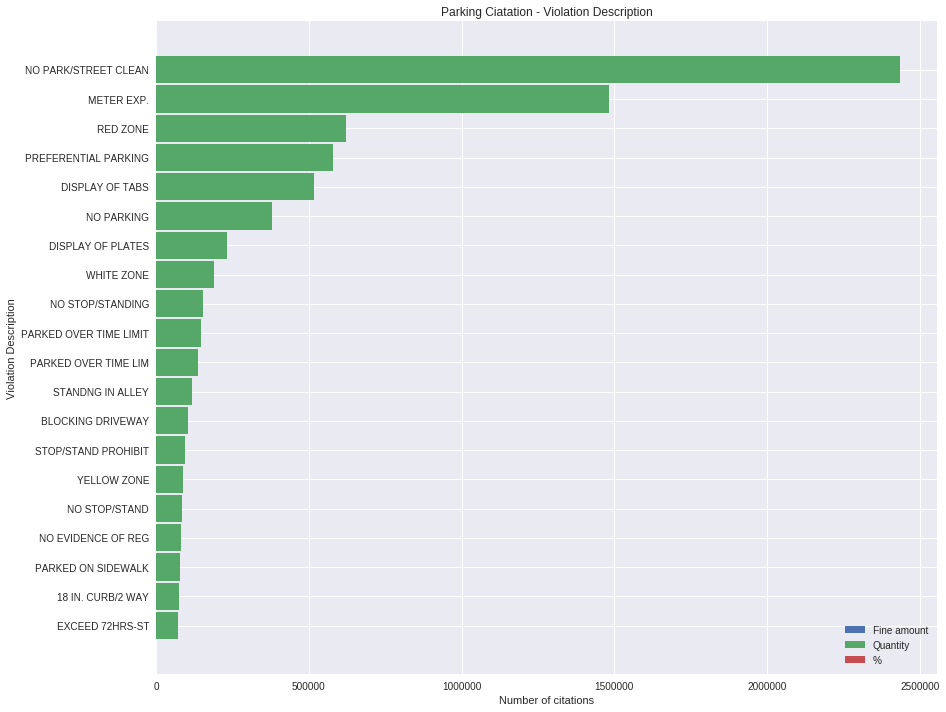

In [0]:
#Graph of the violation description 
violation.groupby(['Violation Description']).sum().sort_values(by= 'Quantity', ascending=True)[-20:].plot(kind='barh',width=2.8,figsize=(14, 12))
plt.xlabel('Number of citations')
plt.title("Parking Ciatation - Violation Description")
plt.show()

In [0]:
#Issue date. 
#Get a numpy array that contains the day of week in words instead of  number. Return a numpy array that contains a list of week day in words 
def issue_date(data_frame):
 
  date=np.empty(len(data_frame), dtype="U9")
  i=0
  for data in data_frame: 
    temp=datetime.date(int(data[:4]),int(data[5:7]),int(data[8:10]))
    date[i]=calendar.day_name[temp.weekday()]
    i+=1
  return date

#Analize the issue date 
day_of_week=pd.DataFrame()
#drop all nan values 
temp= df['Issue Date'].dropna()
day_of_week['Issue Date']=temp
day_of_week['day_of_week']=issue_date(temp)

quantity=np.ones(len(day_of_week),dtype=int)
day_of_week['Quantity'] = quantity
#Reduce the week day.
day_of_week['Quantity']=day_of_week['Quantity'].groupby(day_of_week['day_of_week']).transform('sum')
day_of_week['%'] = (day_of_week['Quantity']/len(day_of_week))*100
#drop the duplicate data 
day_of_week=day_of_week.drop_duplicates(['day_of_week']).sort_values(by = ['Quantity'], ascending = [False])
print (day_of_week.head(day_of_week.shape[0]))
#upload_file('weekday.csv',weekday)

             Issue Date day_of_week  Quantity          %
4   2015-09-15T00:00:00     Tuesday   1640958  19.457359
6   2015-12-17T00:00:00    Thursday   1584621  18.789354
17  2015-09-16T00:00:00   Wednesday   1552237  18.405366
21  2015-12-18T00:00:00      Friday   1374309  16.295618
0   2015-12-21T00:00:00      Monday   1365862  16.195459
3   2015-12-26T00:00:00    Saturday    485931   5.761838
14  2015-12-27T00:00:00      Sunday    429693   5.095006


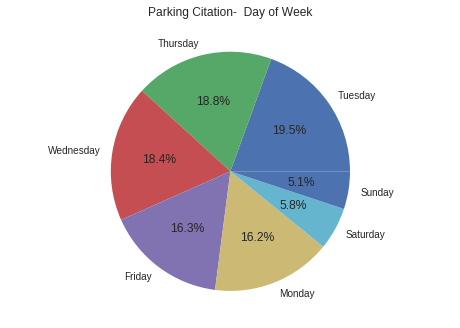

In [0]:
#Graph the week day
average=day_of_week['%']
plt.axis('equal')
plt.pie(average, labels=day_of_week['day_of_week'],autopct='%1.1f%%')
plt.title("Parking Citation-  Day of Week")
plt.show()

In [0]:
#Fine amount 
total_fine_amount=df['Fine amount'].sum()
print('Total fine amount: $', total_fine_amount)

#Execution time
runtime=time.time()-runtime
print('Execution time:', runtime,'sec')

Total fine amount: $ 590644016.0
Execution time: 119.14040184020996 sec
